In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pywr.uncertainties.uncertainty import uncertainty
from pywr.uncertainties.format import rounded_uncertainty_with_nominal_value
from pywr.uncertainties.devices import BRYMEN_BM811_CURRENT, BRYMEN_BM811_VOLTAGE

In [93]:
COVERED_DATA_PATH = "data/cov.csv"

In [94]:
def compute_uncertainties(df: pd.DataFrame) -> pd.DataFrame:
    """Compute uncertainties for the given DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with the data.

    Returns:
        pd.DataFrame: DataFrame with the data and uncertainties.
    """
    df["u(U)"] = df["U"].apply(
        lambda u: uncertainty(abs(u), 0.001, BRYMEN_BM811_VOLTAGE)
    )
    df["u(I)"] = df["I"].apply(
        lambda i: uncertainty(abs(i), 0.001, BRYMEN_BM811_CURRENT)
    )
    df["ln(I)"] = df["I"].apply(np.abs).apply(np.log)
    df["u(ln(I))"] = [
        abs(u_i / i) if i != 0 else 0 for i, u_i in zip(df["I"], df["u(I)"])
    ]

    return df

In [95]:
def format_sample_data(df: pd.DataFrame) -> pd.DataFrame:
    voltage_with_uncertainty = [
        rounded_uncertainty_with_nominal_value(u, uu)
        for u, uu in zip(df["U"], df["u(U)"])
    ]
    current_with_uncertainty = [
        rounded_uncertainty_with_nominal_value(i, ui)
        for i, ui in zip(df["I"], df["u(I)"])
    ]

    logarithm_with_uncertainty = [
        rounded_uncertainty_with_nominal_value(ln_i, u_ln_i)
        for ln_i, u_ln_i in zip(df["ln(I)"], df["u(ln(I))"])
    ]

    df["U"], df["u(U)"] = [u for u, _ in voltage_with_uncertainty], [
        uu for _, uu in voltage_with_uncertainty
    ]
    df["I"], df["u(I)"] = [i for i, _ in current_with_uncertainty], [
        ui for _, ui in current_with_uncertainty
    ]

    df["ln(I)"], df["u(ln(I))"] = [ln_i for ln_i, _ in logarithm_with_uncertainty], [
        u_ln_i for _, u_ln_i in logarithm_with_uncertainty
    ]

    df = df.reindex(columns=["U", "u(U)", "I", "u(I)", "ln(I)", "u(ln(I))"])

    return df

# Covered photodiode

## Sample data for covered photodiode

In [96]:
def predicate(row):
    return row["I"] > 0 and row["ln(I)"] > 0 and row["u(ln(I))"] < 0.1


df = pd.read_csv(COVERED_DATA_PATH, sep=";")
df = compute_uncertainties(df)
sample = df.loc[df.apply(predicate, axis=1)].sample(10)
sample = format_sample_data(sample)
sample.sort_values(by="U", inplace=True)
sample.reset_index(drop=True, inplace=True)
display(sample)

,U,u(U),I,u(I),ln(I),u(ln(I))
0,637.0,1.4,3.40,0.23,1.225,0.069
1,716.0,1.4,8.40,0.24,2.129,0.029
2,728.0,1.4,9.60,0.24,2.261,0.025
3,734.0,1.4,10.21,0.24,2.323,0.024
4,734.0,1.4,10.14,0.24,2.316,0.024
5,738.0,1.4,10.64,0.24,2.364,0.023
6,748.0,1.4,11.81,0.24,2.469,0.021
7,753.0,1.4,12.34,0.25,2.513,0.020
8,801.0,1.4,19.83,0.25,2.987,0.013
9,871.0,1.5,36.00,0.27,3.5835,0.0076


## Voltage-current 

<ErrorbarContainer object of 3 artists>

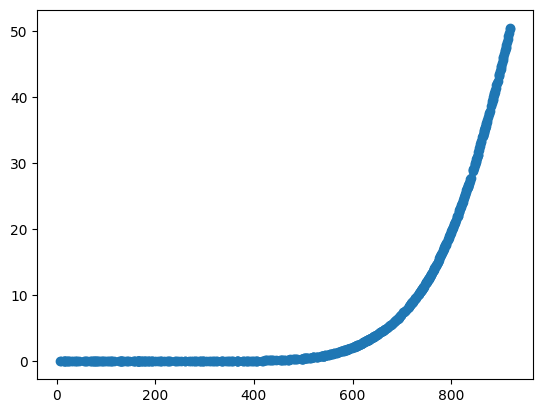

In [97]:
df = pd.read_csv(COVERED_DATA_PATH, sep=";")
df = compute_uncertainties(df)

plt.figure()
plt.errorbar(df["U"], df["I"], xerr=df["u(U)"], yerr=df["u(I)"], fmt="o")

## Logarithmic scale

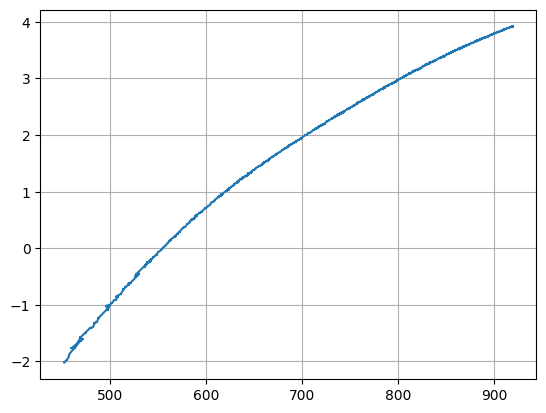

In [103]:
def predicate(row):
    return row["U"] > 450


df = pd.read_csv(COVERED_DATA_PATH, sep=";")
df = df.loc[df.apply(predicate, axis=1)]
df = compute_uncertainties(df)

plt.figure()
plt.errorbar(df["U"], df["ln(I)"], xerr=df["u(U)"])
plt.grid()
plt.show()